In [1]:
%matplotlib nbagg

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from functools import partial

# dtype=str

mem_df = pd.read_excel('memrefs_train_andor_validate.xlsx', header=None, names=['Mem_Acc'], \
                       converters={"Mem_Acc": partial(int, base=16)})

In [2]:
mem_df.head(10)

,Mem_Acc
0,3216124696
1,3216124692
2,3216124688
3,3216124684
4,3216124696
5,3216124692
6,3216124688
7,3216124684
8,3216124696
9,3216124692


In [3]:
mem_df.describe()

,Mem_Acc
count,4.000000e+05
mean,2.328620e+09
std,1.388813e+09
min,1.345136e+08
25%,1.365629e+08
50%,3.216124e+09
75%,3.216124e+09
max,3.216129e+09


We can observe that the mean and the max differ by a factor of 10. Also, the values over $50\%$ of the dataset have very little deviance. We could add some more features, for example frequency of values and a binary column to suggest if that memory value belongs in High or Low memory.

In [4]:
mem_df['Freq'] = mem_df.groupby('Mem_Acc')['Mem_Acc'].transform('count')

In [5]:
mem_df.head(10)

,Mem_Acc,Freq
0,3216124696,160
1,3216124692,220
2,3216124688,224
3,3216124684,230
4,3216124696,160
5,3216124692,220
6,3216124688,224
7,3216124684,230
8,3216124696,160
9,3216124692,220


<IPython.core.display.Javascript object>


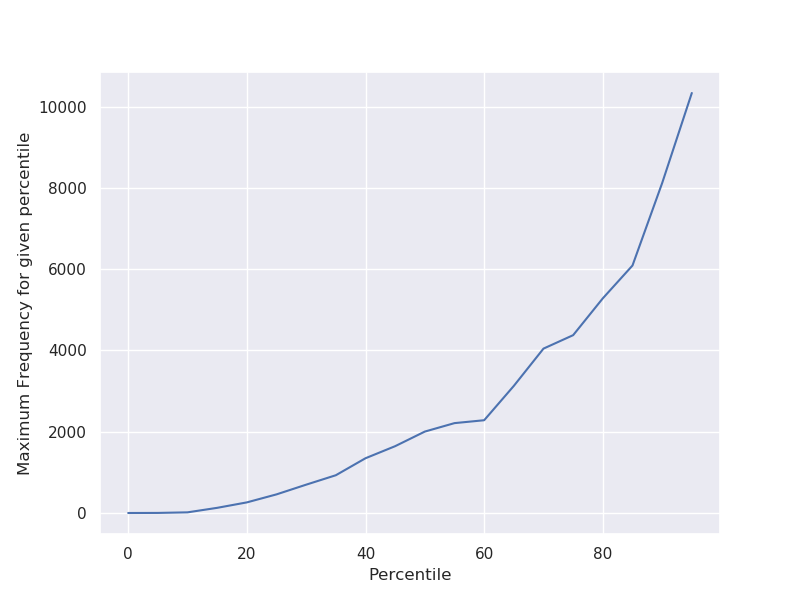

In [6]:
sns.set(style='darkgrid')
plt.figure(figsize=(8,6))
percentiles = [np.percentile(mem_df['Freq'], p) for p in range(0, 100, 5)]
sns.lineplot(range(0, 100, 5), percentiles)
plt.xlabel('Percentile')
plt.ylabel('Maximum Frequency for given percentile')
plt.show()

We can observe an elbow on the $60^{th}$ percentile, so let's check the value, and set it as a cutoff frequency

In [7]:
print(np.percentile(mem_df['Freq'], 60))

2283.0


Apply normalization to the memory references

In [8]:
#mem_df['Mem_Acc'] = (mem_df['Mem_Acc'] - mem_df['Mem_Acc'].min())/(mem_df['Mem_Acc'].max() - mem_df['Mem_Acc'].min())

<IPython.core.display.Javascript object>


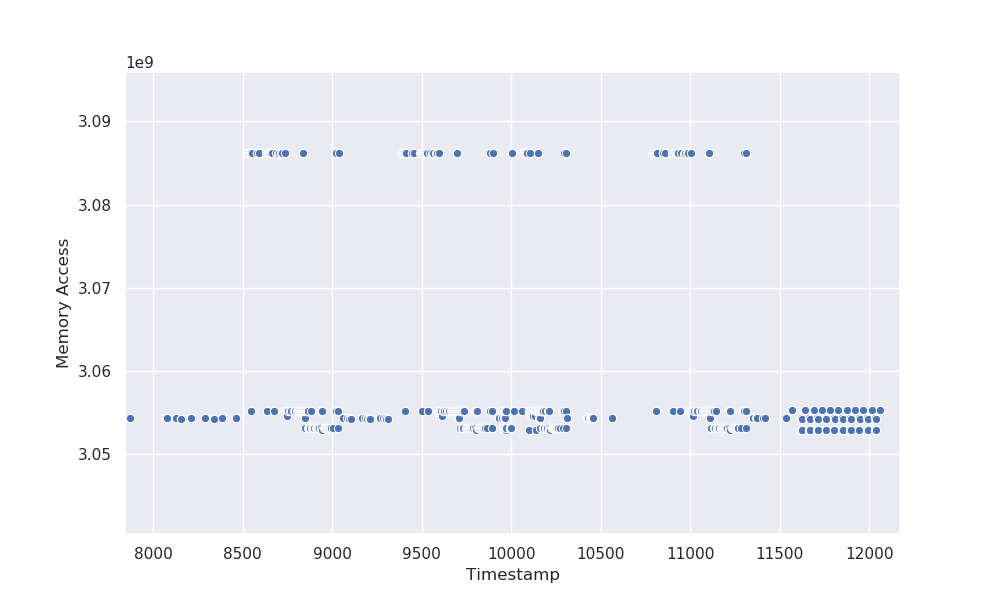

In [10]:
plt.figure(figsize=(10,6))
sns.scatterplot(mem_df.index[:100000], mem_df['Mem_Acc'][:100000])
plt.xlabel('Timestamp')
plt.ylabel('Memory Access')
plt.show()

We could also get a histogram or a kdeplot for our frequencies

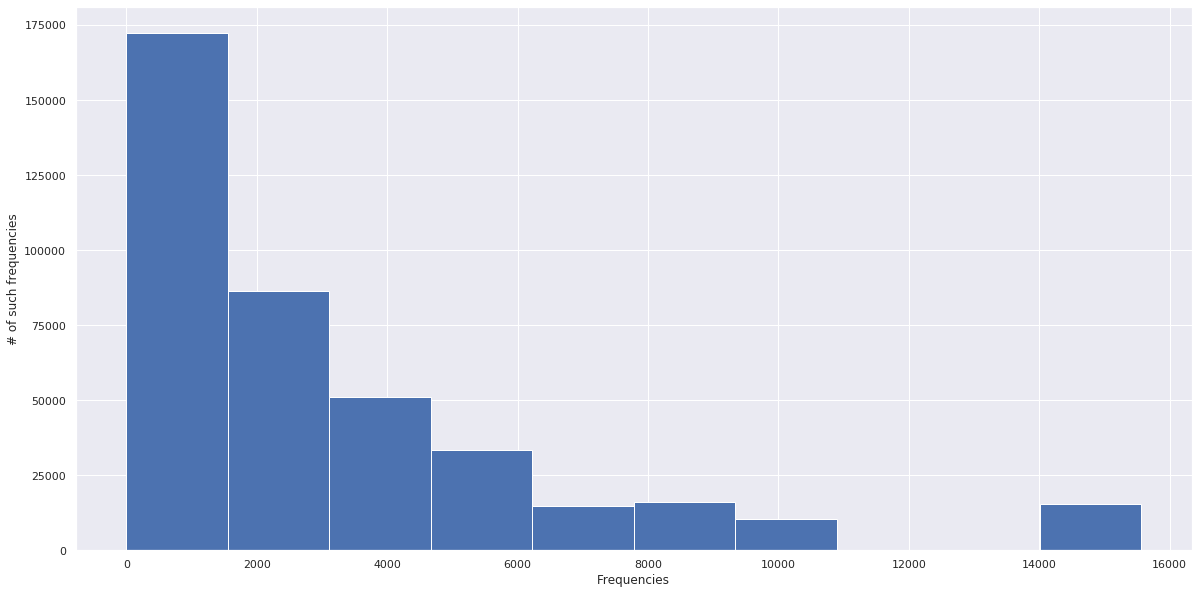

In [10]:
frequencies = np.array(mem_df['Freq'])
plt.figure(figsize=(20, 10))
plt.hist(frequencies)
plt.xlabel('Frequencies')
plt.ylabel('# of such frequencies')
plt.show()

Also, memory accessses above 0.85 will be considered "high memory". whilst all other accesses (seemingly those close to 0), will be "low memory".

So we can thus create a label feature.

In [19]:
mem_df['Deltas'] = mem_df.Mem_Acc.diff().shift(-1)

In [21]:
mem_df.tail()

,Mem_Acc,Freq,Deltas
399995,3216124280,5282,-4.0
399996,3216124276,3128,12.0
399997,3216124288,7150,-16.0
399998,3216124272,7575,-4.0
399999,3216124268,4455,NaN


In [26]:
mem_df['Deltas'].unique().size

30472

So, 30472 unique deltas. Now we just have to only get those that are present more than 10 times.

In [38]:
vocab = mem_df.groupby('Deltas')['Deltas'].transform('count')

In [29]:
vocab = vocab.loc[lambda s : s>=10]

In [33]:
vocab.describe()

count    355095.000000
mean      24161.003717
std       26249.690928
min          10.000000
25%         916.000000
50%        6122.000000
75%       55455.000000
max       62694.000000
Name: Deltas, dtype: float64